In [35]:
# random forest classifier
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt


# f1, precision, recall, weighted accuracy
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    balanced_accuracy_score,
)

# xgboost classifier

from xgboost import XGBClassifier

# lightgbm classifier

from lightgbm import LGBMClassifier

# catboost classifier

from catboost import CatBoostClassifier

import pandas as pd

# Adaboot classifier
from sklearn.ensemble import AdaBoostClassifier

# SVM

from sklearn.svm import SVC

# KNN

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

In [3]:
dataset = pd.read_csv(f"{RAW_DIR}/fetal_health.csv")

## Removing histogram features 
'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',

In [4]:
# Remove columns that have histogram data

dataset_without_hist = dataset.drop(columns=['histogram_width',
                                    'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
                                             'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
                                             'histogram_median', 'histogram_variance', 'histogram_tendency'])

In [5]:
dataset_without_hist.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'fetal_health'],
      dtype='object')

In [6]:
label2class = {
    1: "Normal",
    2: "Suspect",
    3: "Pathology"
}

labeel2class_encoded = {
    0: "Normal",
    1: "Suspect",
    2: "Pathology"
}

In [7]:
# split (train, test) stratified and save into processed directory

train, test = train_test_split(
    dataset, test_size=0.1, stratify=dataset["fetal_health"], random_state=42
)

train.to_csv(f"{PROCESSED_DIR}/train.csv", index=False)

test.to_csv(f"{PROCESSED_DIR}/test.csv", index=False)

In [8]:
train_without_hist, test_without_hist = train_test_split(
    dataset_without_hist, test_size=0.1, stratify=dataset_without_hist["fetal_health"], random_state=42
)

train_without_hist.to_csv(
    f"{PROCESSED_DIR}/train_without_hist.csv", index=False)

test_without_hist.to_csv(f"{PROCESSED_DIR}/test_without_hist.csv", index=False)

In [9]:
x_train = train.drop("fetal_health", axis=1)
y_train = train["fetal_health"]

y_train = LabelEncoder().fit_transform(y_train)

In [10]:
x_train_without_hist = train_without_hist.drop("fetal_health", axis=1)
y_train_without_hist = train_without_hist["fetal_health"]

y_train_without_hist = LabelEncoder().fit_transform(y_train_without_hist)

In [11]:
x_train.shape, y_train.shape

((1913, 21), (1913,))

In [12]:
x_train_without_hist.shape, y_train_without_hist.shape

((1913, 11), (1913,))

In [22]:
models = [
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier(verbosity=-1)),
    ("CatBoost", CatBoostClassifier(logging_level="Silent")),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC()),
    ("KNN", KNeighborsClassifier())
]

In [24]:
FOLDS = 10

In [36]:
# Define the models and their corresponding parameter grids
models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 6, 9],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(verbosity=-1),
        "params": {
            "num_leaves": [31, 62, 128],
            "max_depth": [10, 20, 30],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(logging_level="Silent"),
        "params": {
            "iterations": [100, 200, 300],
            "depth": [4, 6, 10],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
            "algorithm": ['SAMME', 'SAMME.R']
        }
    },
    "SVM": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf', 'poly'],
            "gamma": ['scale', 'auto']
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance'],
            "algorithm": ['auto', 'ball_tree', 'kd_tree']
        }
    }
}

In [19]:
# standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)

x_train_scaled_without_hist = scaler.fit_transform(x_train_without_hist)

### With Histogram

In [39]:
# Apply GridSearchCV for each model
best_estimators = {}
for model_name, mp in models_params.items():
    grid_search = GridSearchCV(
        mp['model'], mp['params'], cv=FOLDS, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(x_train if model_name not in ["SVM", "KNN"] else x_train_scaled,
                    y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.9460335418078298
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best score for XGBoost: 0.9559144488811109
Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 30, 'num_leaves': 128}
Best score for LightGBM: 0.9562805940977057
Best parameters for CatBoost: {'depth': 6, 'iterations': 300, 'learning_rate': 0.3}
Best score for CatBoost: 0.9514964353387793


/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The

Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
Best score for AdaBoost: 0.911510092353058
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.9302161637944917
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.9135731127401387


In [41]:
print(best_estimators)

{'Random Forest': RandomForestClassifier(max_depth=20, n_estimators=200), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...), 'LightGBM': LGBMClassifier(max_depth=30, num_leaves=128, verbosity=-1), 'CatBoost': <catboost.core.CatBoostClassifier object at 0x7e9b60e52d40>, 'AdaBoo

In [43]:
best_estimators['XGBoost']

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

The best model was the XGBoost with a f1 of 0.956, using a learning rate of 0.1, max_depth of 3, n_estimators of 300.

### Without Histogram

In [53]:
# Apply GridSearchCV for each model
best_estimators_without_estimators = {}
for model_name, mp in models_params.items():
    grid_search = GridSearchCV(
        mp['model'], mp['params'], cv=FOLDS, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(x_train_without_hist if model_name not in ["SVM", "KNN"] else x_train_scaled_without_hist,
                    y_train_without_hist)
    best_estimators_without_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Best parameters for Random Forest: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.9429175004660271
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Best score for XGBoost: 0.9431554617054811
Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': 30, 'num_leaves': 128}
Best score for LightGBM: 0.9397498488393738
Best parameters for CatBoost: {'depth': 4, 'iterations': 200, 'learning_rate': 0.3}
Best score for CatBoost: 0.945287982730173


/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gobots/.local/share/virtualenvs/MC906-ztYv0O8D/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The

Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
Best score for AdaBoost: 0.9101338435496688
Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score for SVM: 0.9196092803360513
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score for KNN: 0.9208197520602814


In [45]:
best_estimators_without_estimators

{'Random Forest': RandomForestClassifier(max_depth=20, min_samples_split=5),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=9, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='multi:softprob', ...),
 'LightGBM': LGBMClassifier(max_depth=20, num_leaves=62, verbosity=-1),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x7e9c07504fd0>,

Using the histograms features makes no great difference in the model (2% of difference in F1 weighted score), so it's possible to assume that those features are not part of a data leakage.

## Tests

In [54]:
# test the model with the test set
test_results = {model: {} for model, _ in models}


def test_model(model, x_test, y_test):
    y_test = LabelEncoder().fit_transform(y_test)

    y_pred = model.predict(x_test)

    f1 = f1_score(y_test, y_pred, average="weighted")
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Balanced Accuracy: {balanced_accuracy}")

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "balanced_accuracy": balanced_accuracy,
    }


x_test = test.drop("fetal_health", axis=1)

y_test = test["fetal_health"]

x_test_without_hist = test_without_hist.drop("fetal_health", axis=1)

y_test_without_hist = test_without_hist["fetal_health"]

print('With histogram data')

test_results['XGBoost'] = test_model(
    best_estimators['XGBoost'], x_test, y_test)

print('Without histogram data')

test_results['XGBoost'] = test_model(
    best_estimators_without_estimators['CatBoost'], x_test_without_hist, y_test_without_hist)

With histogram data
F1: 0.9337340391459756
Precision: 0.933932986479032
Recall: 0.9342723004694836
Balanced Accuracy: 0.8724630322054501
Without histogram data
F1: 0.9164358765797183
Precision: 0.9183279636921735
Recall: 0.9154929577464789
Balanced Accuracy: 0.8644309036913939


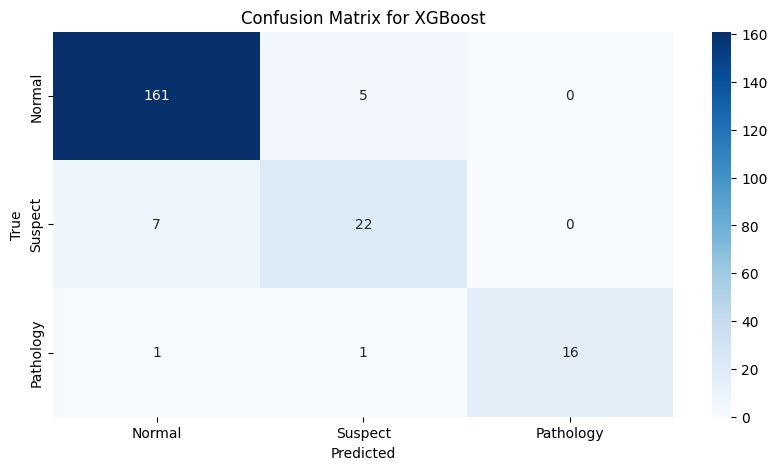

In [56]:
# matrix confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = LabelEncoder().fit_transform(y_test)


model = best_estimators['XGBoost']
y_pred = model.predict(x_test)

c = confusion_matrix(y_test, y_pred)

# plot

plt.figure(figsize=(10, 5))

sns.heatmap(c, annot=True, fmt="d", cmap="Blues",
            xticklabels=[label2class[i] for i in range(1, 4)],
            yticklabels=[label2class[i] for i in range(1, 4)])

plt.title(f"Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.show()

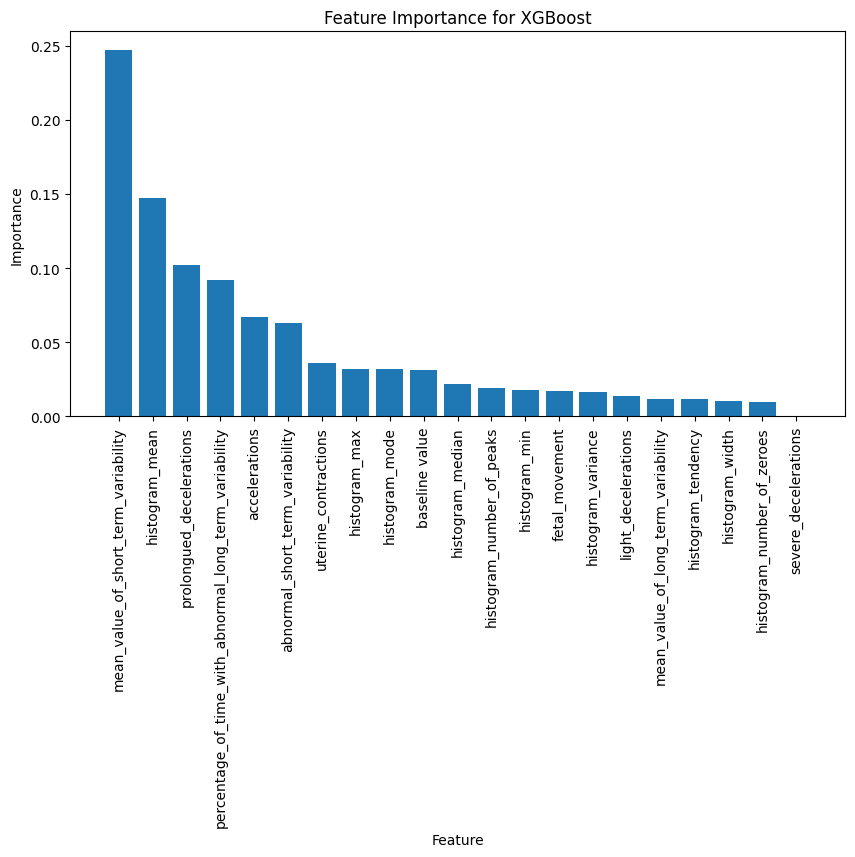

In [58]:
# plot feature importance for all models

model = best_estimators['XGBoost']

importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))

plt.bar(
    x_train.columns[indices],
    importances[indices],
)

plt.title(f"Feature Importance for XGBoost")

plt.xlabel("Feature")

plt.ylabel("Importance")

plt.xticks(rotation=90)


plt.show()